In [15]:
import alpaca_trade_api as tradeapi
import pandas as pd
from alpaca_trade_api.rest import REST, TimeFrame
import datetime as dt
import numpy as np
import altair as alt
import math
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor, XGBClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Senior Project

In [20]:
api = tradeapi.REST('AKP5ZTIF1EZY9IFOX8PW', '8tz0hS5SLcAGYQNR5yW6XoGOXIQ4Ehb6q270ELNK', 'https://api.alpaca.markets')

## Pull in Data from API

In [21]:
instances = 1000

symbols = ['GOOG', 'AAPL', 'ROKU']

datasets = []

for ticker in symbols:

    stock_data = api.get_barset(ticker, 'day', limit=instances)

    stock_data = pd.DataFrame(stock_data.df)

    stock_data.columns = stock_data.columns.droplevel()

    stock_data = stock_data.reset_index()

    stock_data['symbol'] = ticker

    datasets.append(stock_data)
    

pd.set_option("display.max_rows", 10, "display.max_columns", None)

AttributeError: 'REST' object has no attribute 'get_barset'

## Feature Creation:

For feature creation I must first decide what I want the data table to look like. I would like to create a big datatable with data from multiple stock tickers and each row represents one stock for one day. Because the target variable is the price for the next day I would also like to create features that revolve around the stock conditions for the current day. This mainly revolves around the price and volume.


Here, instead of having a single timestamp, I would like to separate it into several columns for day, month, and year.

In [1352]:
for df in datasets:

    df["total_high"] = df["high"].max()

    df['day'] = df["time"].dt.day

    df['week'] = df["time"].dt.week

    df['month'] = df["time"].dt.month

    df['year'] = df["time"].dt.year


C:\Users\riley\AppData\Local\Temp/ipykernel_18180/191631716.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['week'] = df["time"].dt.week


Finding the weekly, monthly, and yearly maximums for price and volume.

In [1353]:

for df in datasets:

    df['week_high'] = df.groupby(['week','month','year'])['high'].transform('max')

    df['month_high'] = df.groupby(['month', 'year'])['high'].transform('max')

    df['year_high'] = df.groupby(df['year'])['high'].transform('max')

    df['week_max_volume'] = df.groupby(['week','month','year'])['volume'].transform('max')

    df['month_max_volume'] = df.groupby(['month','year'])['volume'].transform('max')

    df['year_max_volume'] = df.groupby(df['year'])['volume'].transform('max')

    df["volume_median"] = df["volume"].median()

    df["day_middle"] = (df["high"] + df["low"]) / 2

This is where most of the features we will use are generated. Including consecutive days a stock ticker has been negative or positive, rolling averages and current price relative to week, month, or year maximums or the rolling average. Because we will be using multiple tickers in the dataset the end goal for my features is that there is a reasonable range in which all columns for all stocks can fit in, this is why you'll see a lot of percentage values rather than the actual price value.

In [1354]:
#price

for df in datasets:

    df['daily_change'] = df.close - df.close.shift()

    df['daily_change_percentage'] = (df.daily_change / df.close.shift()) * 100

    df['daily_positive_change'] = df.daily_change > 1

    df['daily_negative_change'] = df.daily_change < 1

    df["consecutive_days"] = df.daily_positive_change.groupby((df.daily_positive_change != df.daily_positive_change.shift()).cumsum()).cumcount() + 1

    df['consecutive_days_positive'] = df.apply(lambda x: x["consecutive_days"] if x['daily_positive_change'] == True else 0, axis = 1)

    df['consecutive_days_negative'] = df.apply(lambda x: x["consecutive_days"] if x['daily_negative_change'] == True else 0, axis = 1)

    df["median_daily_change"] = df.daily_change.median()

    df["median_loss"] = df["daily_change"].where(df['daily_change'] < 0).median()

    df["median_gain"] = df["daily_change"].where(df['daily_change'] > 0).median()

    df["30_day_rolling_average_percentage_change"] = df["daily_change_percentage"].rolling(30).median()

    df["30_day_rolling_median_price"] = df["day_middle"].rolling(30).median()

    df["price_relative_to_week_high"] = (df.day_middle / df.week_high) * 100

    df["price_relative_to_month_high"] = (df.day_middle / df.month_high) * 100

    df["price_relative_to_year_high"] = (df.day_middle / df.year_high) * 100

    df["price_relative_to_all_time_high"] = (df.day_middle / df.total_high) * 100

    df["price_relative_to_30_rolling_median"] = (df.day_middle / df["30_day_rolling_median_price"]) * 100



Here, I completed the same steps as above but for volume.

In [1355]:
#volume

for df in datasets:

    df['daily_volume_change'] = df.volume - df.volume.shift()

    df['daily_volume_change_percentage'] = (df.daily_volume_change / df.volume.shift()) * 100

    df['daily_volume_positive_change'] = df.daily_volume_change > 1

    df['daily_volume_negative_change'] = df.daily_volume_change < 1

    df["consecutive_days_volume"] = df.daily_volume_positive_change.groupby((df.daily_volume_positive_change != df.daily_volume_positive_change.shift()).cumsum()).cumcount() + 1

    df['consecutive_days_volume_positive'] = df.apply(lambda x: x["consecutive_days_volume"] if x['daily_volume_positive_change'] == True else 0, axis = 1)

    df['consecutive_days_volume_negative'] = df.apply(lambda x: x["consecutive_days_volume"] if x['daily_volume_negative_change'] == True else 0, axis = 1)

    df["median_daily_volume_change"] = df.daily_volume_change.median()

    df["median_volume_loss"] = df["daily_volume_change"].where(df['daily_volume_change'] < 0).median()

    df["median_volume_gain"] = df["daily_volume_change"].where(df['daily_volume_change'] > 0).median()

    df["30_day_rolling_volume_average_percentage"] = df["daily_volume_change_percentage"].rolling(30).median()

    df["30_day_rolling_median_volume"] = df["volume"].rolling(30).median()

    df["volume_relative_to_week_max_volume"] = (df.volume / df.week_max_volume) * 100

    df["price_relative_to_month_max_volume"] = (df.volume / df.month_max_volume) * 100

    df["price_relative_to_year_max_volume"] = (df.volume / df.year_max_volume) * 100

    df["current_volume_relative_to_30_rolling_median"] = (df.volume / df["30_day_rolling_median_volume"]) * 100

I felt it would be best to one-hot-encode my features regarding consecutive days.

In [1356]:
datatables = []

for df in datasets:

    one_hot_encoded = pd.get_dummies(df, columns=['consecutive_days_positive', 'consecutive_days_negative', 'consecutive_days_volume_positive', 'consecutive_days_volume_negative'])

    dropped = one_hot_encoded.drop(columns=['consecutive_days', 'consecutive_days_volume', 'daily_negative_change', 'daily_volume_negative_change', 'time', 'daily_positive_change'])

    datatables.append(dropped)

## Create Different Data Tables for Models

Now I will begin to create three separate data tables based off of the data organized thus far. One table will predict if the next day stock price will be higher or lower(classification), one table will predict the next day percentage rise(regression), and the third table will predict the next day price percentage rise binned. I wanted these seperate tables to see which one works better in the final result.

First data table (classification). My target variable is simply whether the next day price change will be higher or lower. In this step(for all tables), we will be dropping several columns previously created that may skew data results to certain stock.

In [1357]:
yes_or_no = []

#get target
for df in datatables:

  df["is_next_day_positive"] = df.daily_change_percentage.shift(-1) > 1

  dropped = df.drop(columns=['open', 'high', 'low', 'close', 'volume','symbol', 'total_high', 'week_high', 'month_high', 'year_high', 'week_max_volume', 'month_max_volume',
    'year_max_volume', 'volume_median', 'day_middle', 'daily_change', 'median_daily_change', '30_day_rolling_median_price', '30_day_rolling_median_volume','daily_volume_change', 'median_loss', 'median_gain', 'median_daily_volume_change', 'median_volume_loss',
    'median_volume_gain', 'daily_volume_positive_change'])

#delete first 30 rows(too many null values)
  less_rows = dropped.iloc[30: , :]

  data = less_rows.reset_index(drop = True)

  last_row_dropped = data = data[:-1]

  yes_or_no.append(last_row_dropped)

In [1358]:
yes_or_no_final = pd.concat(yes_or_no)

yes_or_no_final = yes_or_no_final.fillna(0)

Second data table (regression)

In [1359]:
number_prediction = []

#get target
for df in datatables:

  df["is_next_day_positive"] = df.daily_change_percentage.shift(-1)

  dropped = df.drop(columns=['open', 'high', 'low', 'close', 'volume','symbol', 'total_high', 'week_high', 'month_high', 'year_high', 'week_max_volume', 'month_max_volume',
    'year_max_volume', 'volume_median', 'day_middle', 'daily_change', 'median_daily_change', '30_day_rolling_median_price', '30_day_rolling_median_volume','daily_volume_change', 'median_loss', 'median_gain', 'median_daily_volume_change', 'median_volume_loss',
    'median_volume_gain', 'daily_volume_positive_change'])

  less_rows = dropped.iloc[30: , :]

  data = less_rows.reset_index(drop = True)

  last_row_dropped = data = data[:-1]

  number_prediction.append(last_row_dropped)

In [1360]:
binned_data = number_prediction

number_prediction = pd.concat(number_prediction)

number_prediction = number_prediction.fillna(0)

Third data table(classification binned).
I ran into some trouble with this one and the code is sloppy but it should work now.

In [1361]:
binned_data = pd.concat(binned_data)

binned_data = binned_data.fillna(0)

In [1362]:
#create bins

columns_to_bin = ["daily_change_percentage", '30_day_rolling_average_percentage_change', 'price_relative_to_week_high', 
    'price_relative_to_month_high', 'price_relative_to_year_high', 'price_relative_to_all_time_high', 'price_relative_to_30_rolling_median', 'daily_volume_change_percentage', 
    '30_day_rolling_volume_average_percentage', 'volume_relative_to_week_max_volume', 'price_relative_to_month_max_volume', 'price_relative_to_year_max_volume', 
    'current_volume_relative_to_30_rolling_median', "is_next_day_positive"]

bins = 20

for column in columns_to_bin:

    #df[column] = pd.qcut(df[column].rank(method='first'), bins)
    binned_data[column] = pd.qcut(binned_data[column], bins, duplicates='drop')

    

Save data to csv files.

In [1363]:
yes_or_no_final.to_csv('yes_or_no.csv')
binned_data.to_csv('binned_data.csv')
number_prediction.to_csv('number_prediction.csv')

PermissionError: [Errno 13] Permission denied: 'yes_or_no.csv'

## Creating the Models
I decided to try a Random Forest, XGBoost, and Neural Networks. All of the models are working, but I haven't quite found the parameter I want yet.

First, separate the data from each table to show the x and y variables.

In [1364]:
X_yes_or_no = yes_or_no_final.drop(columns = ['is_next_day_positive'])
y_yes_or_no = yes_or_no_final['is_next_day_positive']

X_binned = binned_data.drop(columns = ['is_next_day_positive'])
y_binned = binned_data['is_next_day_positive']

X = number_prediction.drop(columns = ['is_next_day_positive'])
y = number_prediction['is_next_day_positive']

### Random Forest

Higher or Lower Classification Model:

In [1365]:
#Random forest

X_train, X_test, y_train, y_test = train_test_split(X_yes_or_no, y_yes_or_no, test_size = .3, random_state = 1)

forest_model = RandomForestClassifier(max_depth = 2, random_state=1)
forest_model.fit(X_train, y_train)

y_pred = forest_model.predict(X_test)

predictions = pd.DataFrame(y_pred)

predictions = predictions.rename(columns={0: "predictions"})

actual = pd.DataFrame(y_test)

actual = actual.reset_index(drop = True)

results = pd.concat([predictions, actual], axis=1)

results

,predictions,is_next_day_positive
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
868,False,False
869,False,True
870,False,True
871,False,False


Here, cross validation is used to check for overfitting. Basically we are testing the model with five different, random sections of the data.

In [1366]:
scores = cross_val_score(forest_model, X_yes_or_no, y_yes_or_no, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.69 accuracy with a standard deviation of 0.00


Show what features were most important in finding the results.

In [1368]:
feature_dat = pd.DataFrame({
    "values": forest_model.feature_importances_,
    "features": X_train.columns
    }) 
alt.Chart(feature_dat.query('values > .02'),title = "Most Important Features").encode(
    alt.X('values'), 
    alt.Y('features', sort = "-x")).mark_bar()

alt.Chart(...)

This plot shows the predictions vs the actual values.

C:\Users\riley\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


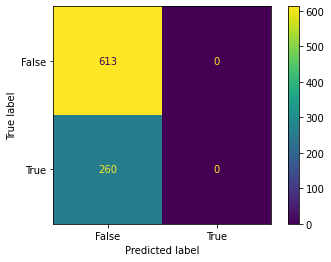

In [1369]:
plot_confusion_matrix(forest_model, X_test, y_test) 

In [1370]:
#XGBoost

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

xgb_model = XGBRegressor(
    learning_rate = 0.1,
    max_depth = 8,
    min_child_weight = 2,
    gamma = 0.5,
    subsample = 0.8,
    colsample_bytree = 0.8,
    scale_pos_weight = 0.3
)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

predictions = pd.DataFrame(y_pred)

predictions = predictions.rename(columns={0: "predictions"})

actual = pd.DataFrame(y_test)

actual = actual.reset_index(drop = True)

results = pd.concat([predictions, actual], axis=1)

results

,predictions,is_next_day_positive
0,0.163646,0.566594
1,0.777627,0.308309
2,-0.188973,0.189404
3,0.017547,1.277594
4,-0.024903,1.393567
...,...,...
577,0.082068,1.161210
578,-0.671946,1.093416
579,1.325861,1.905336
580,0.734949,1.106097


In [1371]:
mse=mean_squared_error(y_test, predictions, squared = False)

print(np.sqrt(mse))

1.6709152774061946


In [1372]:
#Neural Network
train_dataset = number_prediction.sample(frac=0.8, random_state=0)
test_dataset = number_prediction.drop(train_dataset.index)

In [1373]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('is_next_day_positive')
test_labels = test_features.pop('is_next_day_positive')

train_features = np.asarray(train_features).astype('float32')

In [1374]:
normalizer = preprocessing.Normalization()

normalizer.adapt(np.array(train_features))

first = np.array(train_features)

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[ 1. 23.  6. ...  0.  0.  0.]
 [15. 24.  6. ...  0.  0.  0.]
 [ 3. 14.  4. ...  0.  0.  0.]
 ...
 [ 1. 14.  4. ...  0.  0.  0.]
 [10.  2.  1. ...  0.  0.  0.]
 [10. 50. 12. ...  0.  0.  0.]]

Normalized: [[-1.68 -0.26 -0.17 ... -0.02 -0.02 -0.02]
 [-0.09 -0.19 -0.17 ... -0.02 -0.02 -0.02]
 [-1.46 -0.88 -0.78 ... -0.02 -0.02 -0.02]
 ...
 [-1.68 -0.88 -0.78 ... -0.02 -0.02 -0.02]
 [-0.66 -1.72 -1.69 ... -0.02 -0.02 -0.02]
 [-0.66  1.61  1.64 ... -0.02 -0.02 -0.02]]


In [1375]:
features_array = np.array(train_features)

normalizer = preprocessing.Normalization(input_shape=[1,])
normalizer.adapt(features_array)

model = tf.keras.Sequential([
    normalizer,
     layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
])

model.summary()

model.compile(
    optimizer=tf.optimizers.Adam(),
    loss='mean_absolute_error')

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_36 (Normaliza  (None, 58)               117       
 tion)                                                           
                                                                 
 dense_24 (Dense)            (None, 64)                3776      
                                                                 
 dense_25 (Dense)            (None, 64)                4160      
                                                                 
 dense_26 (Dense)            (None, 1)                 65        
                                                                 
Total params: 8,118
Trainable params: 8,001
Non-trainable params: 117
_________________________________________________________________


In [1376]:
%%time
history = model.fit(
    train_features, train_labels,
    epochs=100,
    # suppress logging
    verbose=1,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

Epoch 1/100
59/59 [==============================] - 1s 5ms/step - loss: 1.9479 - val_loss: 2.3234
Epoch 2/100
59/59 [==============================] - 0s 3ms/step - loss: 1.8840 - val_loss: 2.2972
Epoch 3/100
59/59 [==============================] - 0s 3ms/step - loss: 1.8480 - val_loss: 2.2808
Epoch 4/100
59/59 [==============================] - 0s 3ms/step - loss: 1.8223 - val_loss: 2.2798
Epoch 5/100
59/59 [==============================] - 0s 3ms/step - loss: 1.8004 - val_loss: 2.2913
Epoch 6/100
59/59 [==============================] - 0s 3ms/step - loss: 1.7814 - val_loss: 2.2752
Epoch 7/100
59/59 [==============================] - 0s 3ms/step - loss: 1.7578 - val_loss: 2.2678
Epoch 8/100
59/59 [==============================] - 0s 3ms/step - loss: 1.7359 - val_loss: 2.2793
Epoch 9/100
59/59 [==============================] - 0s 3ms/step - loss: 1.7251 - val_loss: 2.2629
Epoch 10/100
59/59 [==============================] - 0s 2ms/step - loss: 1.6937 - val_loss: 2.2654
Epoch 11/

In [1377]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,0.767003,2.529469,95
96,0.749054,2.550456,96
97,0.771062,2.520028,97
98,0.776497,2.548292,98
99,0.746987,2.535909,99
